# TP Analyse de sensibilité

Dans ce TP on va mener une analyse de sensibilité du modèle de transfert de chaleur en milieu poreux en régime permanent dans une portion de zone hyporhéique mono-dimensionnelle de hauteur 1m représentée par 100 cellules. La différence de charge entre le haut et le bas de la colonne est de 5cm.

L'analyse de sensibilité portera sur les trois paramètres d'entrée de ce modèle, à savoir :

- la perméabilité $K$
- la conductivité thermique du solide $\lambda_s$
- la porosité $n$

Il convient dans un premier temps de caractériser l'incertitude portant sur ces variables et de la modéliser par une loi de probabilité. On va considérer que ces variables sont indépendantes de lois respectives :

- $-\log_{10} K \sim \mathcal{U}(3,10)$
- $\lambda_s \sim \mathcal{U}(1,8)$
- $n \sim \mathcal{U}(0.01,0.5)$

ces données étant issues de la littérature.

On réalisera l'analyse de sensibilité delon la méthode de Sobol' à l'aide du package [SALib](https://salib.readthedocs.io/en/latest/index.html).

## Préambule

Chargement de dépendances et initialisation de la colonne.

In [74]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


Caracteristics of the soil column:
	depth 1.0 m
	depth 1.0 m
	 100 cells of side size 0.01 m
Hydraulic Properties of porous media Unknown
	permeability or hydraulic conductivity: 1.000e-05 m s-1
	porosity: 1.500e-01 --
Thermal Properties of the phase (pure solid) Soil Column
	thermal conductivity:: 2.000e+00 W m-1 K-1
	specific heat capacity:: 9.570e+02 m2 s-2 K-1
	density:: 2.600e+03 kg m-3
equivalent parameters of  Soil Column :
	equivalent thermal conductivity: : 1.737e+00 W m-1 K-1
effective parameters of {}:
 Soil Column
	effective thermal conductivity: 4.151e-07 TO SPECIFY LATER
	permeability:: 1.000e-03 m s-1
	porosity: 1.000e-01 --
	equivalent thermal conductivity:: 1.823e+00 W m-1 K-1


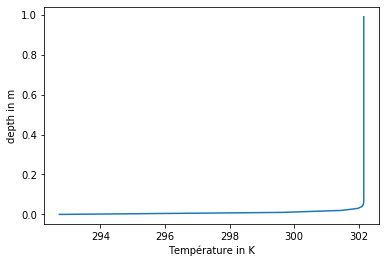

In [3]:
from codepyheat.geometry import Column
from SALib.sample import saltelli
from SALib.analyze import sobol

from codepyheat import JSONPATH
import numpy as np


# step 1
rivBed = Column.fromJsonFile(JSONPATH + "configColumn.json")
rivBed.printProps()

# step 2
rivBed.setHomogeneousPorMed(JSONPATH + "paramColumn.json")
rivBed.physProp.printProps()

# step 3
rivBed.setBcHyd(JSONPATH + "configBcHydro.json")
rivBed.setBcT(JSONPATH + "configBcTemp.json")

# step 4 running forward model with other parameter values
rivBed.runForwardModelSteadyState(1e-3, 2, 0.1,verbose=True, export = True, draw = True) #put the options to False when runnig intensively !


## Analyse de sensibilité

Dans cette partie, on va suivre la démarche décrite dans le [tutoriel](https://salib.readthedocs.io/en/latest/basics.html) de *SALib* en l'adaptant à notre problème.

### Définition du problème


In [5]:
problem = {
    'num_vars': 3,
    'names': ['log10K', 'lambd', 'n'],
    'bounds': [[3,10], 
               [1, 5], 
               [0.01, 0.25]]
}


### Génération du plan d'expérience

Générer le plan d'expérience à l'aide de la fonction `saltelli.sample`. On ne calculera que les indices d'ordre 1 et totaux.


In [6]:
param_values = saltelli.sample(problem, 10000, calc_second_order = False) # generate samples computation of the second order indices by default


### Lancer le modèle 
Exécuter le modèle direct sur les jeux de paramètres générés à l'étape précédente.

In [9]:
Y = np.zeros((param_values.shape[0],rivBed.ncells))

for i, X in enumerate(param_values):
     rivBed.runForwardModelSteadyState(10**(-param_values[i,0]),param_values[i,1],param_values[i,2],verbose=False, export = False, draw = False)
     for j in range(rivBed.ncells):    
        Y[i,j] = rivBed.cell[j].heat.upperT


### Représentation graphique 

Représenter graphiquement 1000 sorties du modèle.

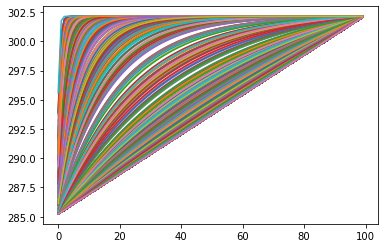

In [10]:
import matplotlib.pyplot as plt

x = np.arange(0,rivBed.ncells)
if (param_values.shape[0] < 1000) :
    plt.plot(x,np.transpose(Y))
else :
    plt.plot(x,np.transpose(Y[np.arange(0,999)]))
plt.show()

### Indices de sensibilité en chaque cellule

Calculer et représenter graphiquement les indices du premier ordre et totaux en fonction du temps. On prendra soin de centrer la sortie en chaque cellule.

In [12]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler(with_std = False).fit(Y)
Y_scaled = std_scale.transform(Y)

Si1_temp = np.zeros((rivBed.ncells,3))
Sit_temp = np.zeros((rivBed.ncells,3))

for i in range(rivBed.ncells):
    Sit = sobol.analyze(problem,Y_scaled[:,i],calc_second_order=False)
    Si1_temp[i,:] = Sit['S1']
    Sit_temp[i,:] = Sit['ST'] 
    

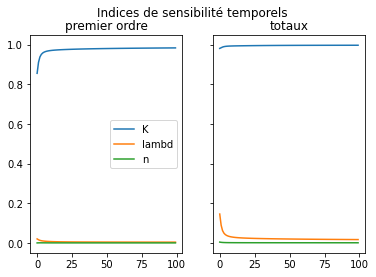

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Indices de sensibilité temporels')
ax1.set_title("premier ordre")
fig1 = ax1.plot(x, Si1_temp)

ax2.set_title("totaux")
fig2 = ax2.plot(x, Sit_temp)
ax1.legend(fig1,("K","lambd","n"))
plt.show()

### Réduction de la dimension

La sortie de notre modèle étant multivariée, il convient d'en réduire la dimension avant d'effectuer le calcul des indices de sensibilité.

Effectuer une ACP sur la sortie du modèle (centrée) et identifier les composantes qui permettent de reproduire 99% de la variance. Pour justifier le choix du nombre de composantes, représenter la proportion de variance cumulée expliquée par les 10 premières composantes.

In [13]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=10)
pca.fit(Y_scaled)

PCA(n_components=10)

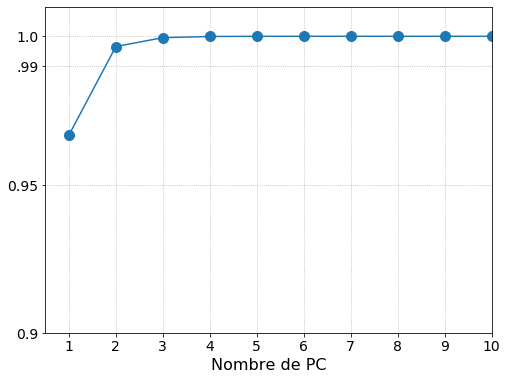

In [14]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
fig, ax = plt.subplots(figsize=(8, 6))

cum_perc = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1, 11), cum_perc, marker='o', markersize=10)

plt.xlabel("Nombre de PC", fontsize='16')

plt.grid(ls=':')

plt.xlim([0.5, 10])
plt.ylim([0.9, 1.01])

# xticks
majorLocator = MultipleLocator(1)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(1)
# major ticks
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
# for the minor ticks, use no labels; default NullFormatter
ax.xaxis.set_minor_locator(minorLocator)
ax.tick_params(labelsize=14)

# yticks
ax.set_yticks([.9, .95, .99, 1.])
ax.set_yticklabels(['0.9', '0.95', '.99', '1.0'])
plt.show()

### Représentation des composantes principales retenues
Représenter les composantes retenues ainsi que l'approximation qui en résulte sur quelques uns des profils générés.

(10, 100)


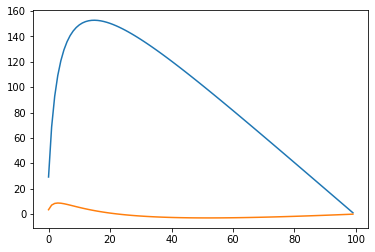

In [17]:
x = np.arange(0,rivBed.ncells)
print(np.shape(pca.components_))
plt.plot(x,pca.explained_variance_[0]*pca.components_[0,:])
plt.plot(x,pca.explained_variance_[1]*pca.components_[1,:])
plt.show()

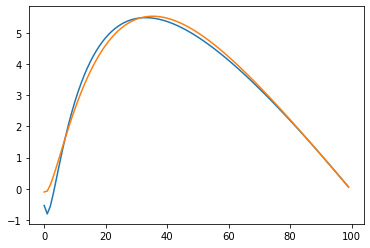

In [18]:
pca = decomposition.PCA(n_components=2)
pca.fit(Y_scaled)
out = pca.transform(Y_scaled)
plt.plot(x,np.matmul(out[0,:],pca.components_))
plt.plot(x,Y_scaled[0,:])
plt.show()

### Calcul des indices univariés

Calculer les indices de Sobol' du premier ordre et totaux pour chaque composante retenue. Les représenter graphiquement.

In [19]:
Si1 = sobol.analyze(problem,out[:,0].flatten(),calc_second_order=False)
print(Si1['S1'])
print(Si1['ST'])

Si2 = sobol.analyze(problem,out[:,1].flatten(),calc_second_order=False)
print(Si2['S1'])
print(Si2['ST'])

[9.79019261e-01 5.45451785e-03 1.84044944e-04]
[9.94415217e-01 2.03172555e-02 8.04934792e-04]
[ 8.69699604e-01  5.96625407e-03 -1.29168946e-04]
[0.999956   0.13056874 0.00535407]


In [20]:
np.shape(out)

(50000, 2)

In [21]:
import pandas as pd
Si_filter = {k:Si1[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
Si_df

,ST,ST_conf,S1,S1_conf
log10K,0.994415,0.019220,0.979019,0.025930
lambd,0.020317,0.001452,0.005455,0.004230
n,0.000805,0.000060,0.000184,0.000781


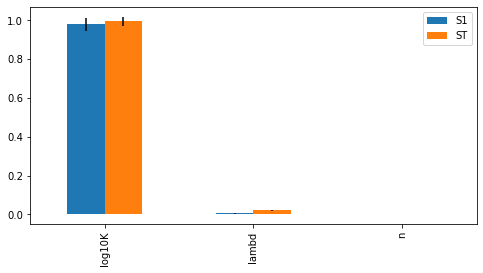

In [89]:
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,4)

plt.show()


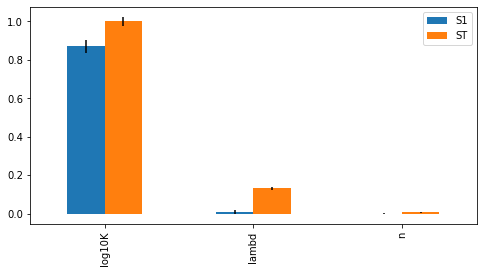

In [22]:

Si_filter = {k:Si2[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
Si_df
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,4)

plt.show()



### Indices généralisés

Calculer les indices généralisés à partir des composantes sélectionnées. Les représenter graphiquement.

In [24]:
print(pca.singular_values_/np.sum(pca.singular_values_))
print((Si1['S1']*pca.singular_values_[0] + Si2['S1']*pca.singular_values_[1])/np.sum(pca.singular_values_))
print((Si1['ST']*pca.singular_values_[0] + Si2['ST']*pca.singular_values_[1])/np.sum(pca.singular_values_))

print(np.shape(out))

[0.8503535 0.1496465]
[9.62659957e-01 5.53109739e-03 1.37173581e-04]
[0.99524438 0.03681601 0.0014857 ]
(50000, 2)


In [25]:
Si_gen = sobol.analyze(problem,np.sum(out,axis=1),calc_second_order=False)
print(Si1['S1'])
print(Si1['ST'])


[9.79019261e-01 5.45451785e-03 1.84044944e-04]
[9.94415217e-01 2.03172555e-02 8.04934792e-04]
